Lab ML for Data Science: Part I

In [1]:
import numpy
import scipy
import torch
import torchvision
from matplotlib import pyplot as plt

# 1 Loading the Data, Preprocessing, Initial Data Analysis

The first step will consist of **downloading the dataset and converting it into numerical tables (e.g. numpy, arrays)**.
In practice, raw data is rarely directly usable as input to machine learning algorithms. In particular, there may be substantial heterogeneity between the different input features. Some features may be physical measurements, monetary measurements, while others may be category indicators or even non-numerical data such as text or images. Hence, a **preliminary filtering** of what is interesting for the analysis we would like to conduct is desirable.

In the context of the UCI wholesale dataset, one may, for example, want to base anomaly and cluster predictions on numerical data (annual spending per category) and drop meta-data such as Channel and the Region indicators or reserve it for an ulterior use. Once such a preliminary step has been taken, we have a standard dataset of size $N × d$ where $N$ is the number of instances (wholesale customers), $d$ is the number of spending categories, and each value in the table can be expressed in monetary unit.

To verify the range and distribution of these values, we can **generate some basic statistical visualizations** of the data. This includes **histograms** showing for each category the distribution of spendings, or **scatter plots** showing the correlation between different product categories. A common observation from such basic statistical analysis is that the distributions are heavy tailed, with many instances having rather small spendings, whereas a few may have spendings one or two orders of magnitude above. 

Any anomaly detection algorithm would systematically highlight those high spenders as anomalous and not make a distinction between spending little and not spending at all.
To address this issue, it can be useful to apply some **nonlinear transformation** to the data, for example, applying the log function to the features so that the distribution becomes compressed for large values and expanded for small values.

$x → log(x + θ)$

Here, we add a positive offset $θ$ in the logarithm so that zero spending $(x = 0)$ does not get mapped to $−∞$. You may experiment with different offsets, such as $θ = 1, θ = 10$ or $θ = 100$. To verify the effect of the transformation, you can **recompute the histograms and scatter plots** in transformed space and check visually whether the transformation had the desired result, e.g. whether the distribution look Gaussian-distributed.

('Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen')


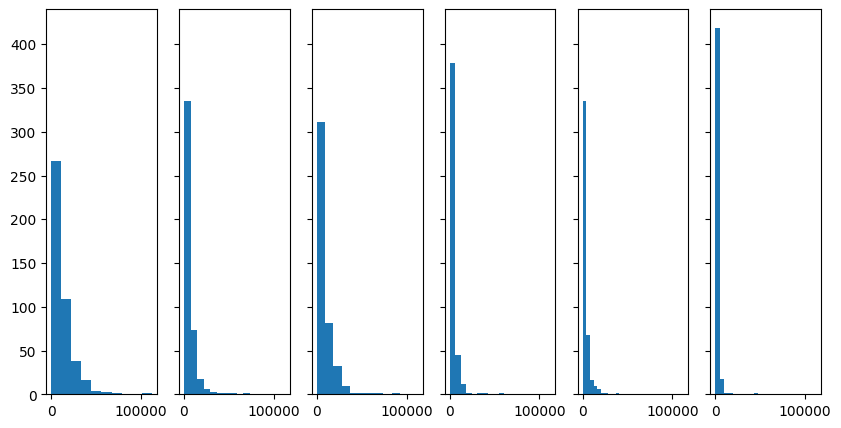

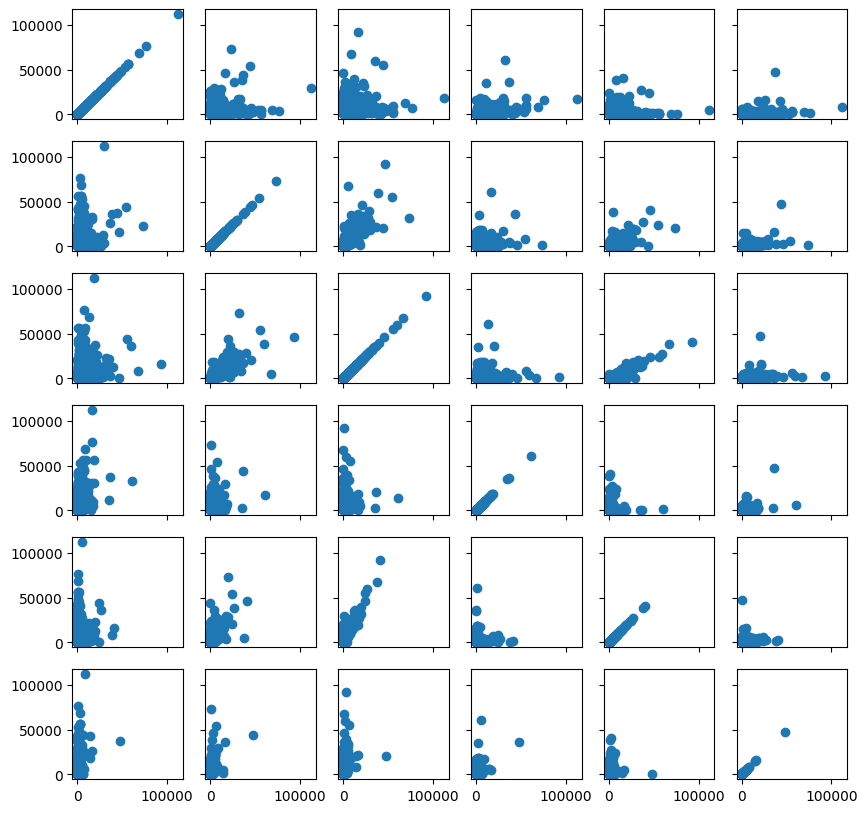

In [50]:
Data = numpy.genfromtxt('Wholesale customers data.csv',
                     delimiter=',',
                     usecols = numpy.arange(2,8),
                     names=True)

categories = Data.dtype.names

print(categories)

fig, axs = plt.subplots(1, 6, sharex = True, sharey=True, figsize=(10, 5))
i = 0
for category in categories:
    axs[i].hist(Data[category])
    i += 1

fig2, axs2 = plt.subplots(6, 6, sharex = True, sharey=True, figsize=(10, 10))

i = 0
for category1 in categories:
    j = 0
    for category2 in categories:
        axs2[i][j].scatter(Data[category1], Data[category2])
        j += 1
    i += 1
#plt.hist(Data['Milk'])
#plt.scatter(Data['Milk'], Data['Grocery'])
plt.show()